In [ ]:
# import packages

# data processing
import pandas as pd
import numpy as np
from datetime import timedelta, datetime


import re

# data visualization
import plotly.graph_objs as go
from plotly.graph_objs import Bar, Layout
from plotly import offline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 10)

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# change text color
import colorama
from colorama import Fore, Style

# IPython
from IPython.display import IFrame

from sklearn.feature_selection import mutual_info_classif

%matplotlib inline

In [ ]:
# 读取数据
train_idx = pd.read_csv("../../data/train_clean.csv",index_col=0).index
test_idx = pd.read_csv("../../data/test_clean.csv",index_col=0).index

In [ ]:
fullset = pd.read_csv("../../data/fullset_update.csv",index_col=0)

C:\Users\gzjgz\AppData\Roaming\Python\Python37\site-packages\numpy\lib\arraysetops.py:580: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [ ]:
train = fullset.loc[train_idx]
test = fullset.loc[test_idx]

In [ ]:
from data_management import meta

In [ ]:
metadata = meta(train,test)

## Encoding

Encoding is the process of converting data into a specified format for secure transmission or storage. The reverse process of encoding is decoding, which extracts the information from the converted format.

### LabelEncoder
In label encoding, each category is assigned a unique integer. This is suitable for ordinal data, where there is an inherent order among the categories. However, for nominal data (categories with no inherent order), using label encoding might introduce unintended relationships between categories.

> Encode target labels with value between 0 and n_classes-1.

```

Usually, we use LabelEncoder to convert nominal variables in encoded data.

For example: Gender, male, female.
We can encode male as 0 and female as 1.

So, when should we use LabelEncoder?？

(1) When the nominal variable is a binary variable, such as gender.
(2) When encoding for binary classification targets.
(3) When the variable is ordinal.

When should we not use it?
(1) When the nominal variable has multiple classes.
(2) When there is no inherent order or comparison relationship between categories.
```



### OrdinalEncoder

> Encode categorical features as an integer array.

OrdinalEncoder主要是转换ordinal，ordinal变量就是带有比较关系的nominal变量。

> both have the same functionality. A bit difference is the idea behind. OrdinalEncoder is for converting features, while LabelEncoder is for converting target variable.That's why OrdinalEncoder can fit data that has the shape of `(n_samples, n_features)` while LabelEncoder can only fit data that has the shape of `(n_samples,)` (though in the past one used LabelEncoder within the loop to handle what has been becoming the job of OrdinalEncoder now)


Advantages: Simple and easy to understand, does not increase data dimensions, friendly to tree-based models.

Disadvantages: Does not capture information from the data, not suitable for linear models, assumes default sequential relationships between categories (which can be addressed by ordinal encoding).

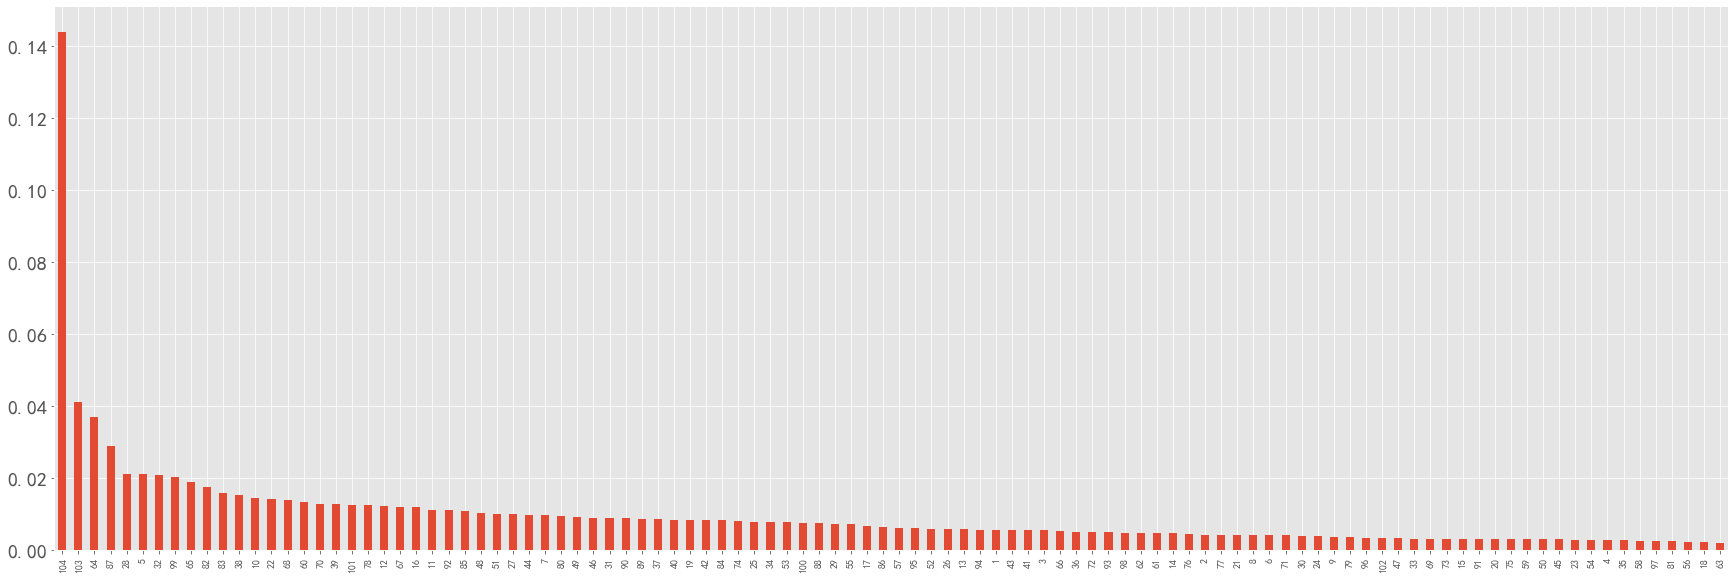

In [ ]:
(fullset.ps_car_11_cat.value_counts()/fullset.shape[0]).plot(kind='bar',figsize = [30,10])
plt.tick_params(axis='y', which='major', labelsize=20)

这一列是nominal的，离散型变量，并且dominant的一类：104（虽然我不懂什么意思），占据整个类别的15%左右，所以我不能认为这一类完全压过了其他类，从而可以忽视其他类别的研究，而且这一列有104个唯一值数量，并且不存在顺序关系。

那么这个时候对这种唯一值过多的列如何编码，就成问题了！

### OneHotEncoder

链接：https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html


> Encode categorical features as a one-hot numeric array.

In [ ]:
nominal_cols = metadata[(metadata.level == 'nominal') & (metadata.keep == True)].index.tolist()
nominal_cols

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_04_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore",sparse=False)
trn_nominal_cols_enc = enc.fit_transform(train[nominal_cols])
tst_nominal_cols_enc = enc.transform(test[nominal_cols])

In [ ]:
trn_nominal_cols_enc.shape

(144626, 177)

In [ ]:
tst_nominal_cols_enc.shape

(892816, 177)

下面来具体看看`OneHotEncoder`怎么使用吧！

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(X)

OneHotEncoder(handle_unknown='ignore')

In [ ]:
# 展示每一类的category
enc.categories_

[array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]

In [ ]:
enc.transform([['Female', 1], ['Male', 4]]).toarray()

array([[1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])

array([['Male', 1],
       [None, 2]], dtype=object)

In [ ]:
enc.get_feature_names_out(['gender', 'group'])

array(['gender_Female', 'gender_Male', 'group_1', 'group_2', 'group_3'],
      dtype=object)


**summary**
1.When the variable type is ordinal, we can use OrdinalEncoder or LabelEncoder for encoding.
2.When the variable type is nominal, we can use OneHotEncoder for encoding.
However, when a column has too many unique values, and using OneHotEncoder results in a large number of columns (e.g., 104 columns), combined with other encoded columns, the overall data dimensionality explodes, significantly impacting the subsequent modeling process. The original 60 dimensions might increase to several hundred.

**Label encoding:**
In fact, the data itself has already undergone label encoding, where categorical data has been replaced with integers.

Pros: Simple and easy to understand, does not increase data dimensions, friendly to tree-based models.
Cons: Does not capture data information, not suitable for linear models, assumes default sequential relationships between categories (which ordinal encoding can address).

**One-hot encoding (dummy encoding):**
For example, in the case of three original data classes, one column is expanded into three columns. Then, for each row, if the value for that row regarding this column was originally "private," in the new three columns, only the WorkClassPrivate column is set to 1, and the other two columns are set to 0. This process is repeated for each row.

### TargetEncoder

就是把类别替换成target关于这一类的均值。

[![bQDkeH.png](https://s4.ax1x.com/2022/03/01/bQDkeH.png)](https://imgtu.com/i/bQDkeH)

First, group by each category, then calculate the mean for each group, and finally replace the original values with these means.

**Advantages:** Does not increase dimensions, establishes a relationship between features and the target.
**Disadvantages:** Due to the distribution information of the target leaking into the features, it may cause data leakage and potential overfitting. If the means of the target for two categories are similar, it may lead to data loss.

In [ ]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # 集散这一列关于target的group mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # 平滑
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # 计算所有target的mean
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    # 如果某一类别的值的个数特别多，比如104这一类就有21255行，那么我们就要削减其关于target的mean的权值。
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # 分别对train和test计算mean
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

-Advantages: Does not increase dimensions, establishes a relationship between features and the target.

-Disadvantages: Due to the target's distribution information leaking into the features, it may cause data leakage and potential overfitting. If the means of the target for two categories are similar, it may lead to data loss.

How to reduce data leakage?

If we directly use the group mean of the target, it would result in data leakage. Therefore, it is necessary to add some noise and smoothing on top of this. How does this work and why is it effective?



In [ ]:
from sklearn.model_selection import train_test_split

X_trn, X_val, y_trn, y_val = train_test_split(
    train.drop('target',axis=1), train.target, test_size=0.2, random_state=1996)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
f_cats = [f for f in X_trn.columns if "_cat" in f]

min_samples_leaf = 100
smoothing = 10
noise_level=0.01

print(f"min_samples_leaf:{Fore.BLUE}{min_samples_leaf}{Style.RESET_ALL}\n"
      f"smoothing:{Fore.BLUE}{smoothing}{Style.RESET_ALL}\n"
      f"noise_level:{Fore.BLUE}{noise_level}{Style.RESET_ALL}")

print("-"*100)
print("%20s   %20s  %25s  %22s" % ("", f"{Fore.BLUE}编码前{Style.RESET_ALL}", 
                                   f"{Fore.RED}编码后{Style.RESET_ALL}", 
                                   f"{Fore.GREEN}前后变化{Style.RESET_ALL}"))
for f in f_cats:
    print("%-20s: " % f, end="")
    tf_scores = []
    f_scores = []
    for trn_idx, val_idx in folds.split(X_trn.values, y_trn.values):
        trn_f, trn_tgt = X_trn[f].iloc[trn_idx], y_trn.iloc[trn_idx]
        val_f, val_tgt = X_trn[f].iloc[trn_idx], y_trn.iloc[trn_idx]
        trn_tf, val_tf = target_encode(trn_series=trn_f, 
                                       tst_series=val_f, 
                                       target=trn_tgt, 
                                       min_samples_leaf=min_samples_leaf, 
                                       smoothing=smoothing,
                                       noise_level=noise_level)
        f_scores.append(max(roc_auc_score(val_tgt, val_f), 1 - roc_auc_score(val_tgt, val_f)))
        tf_scores.append(roc_auc_score(val_tgt, val_tf))
    print(" %.6f ± %.6f | %6f ± %.6f | %6f" 
          % (np.mean(f_scores), np.std(f_scores), np.mean(tf_scores), np.std(tf_scores), np.mean(tf_scores)-np.mean(f_scores)))

min_samples_leaf:100
smoothing:10
noise_level:0.01
----------------------------------------------------------------------------------------------------
                               编码前               编码后           前后变化
ps_ind_02_cat       :  0.508104 ± 0.000422 | 0.509742 ± 0.001206 | 0.001637
ps_ind_04_cat       :  0.512504 ± 0.000825 | 0.513386 ± 0.001310 | 0.000883
ps_ind_05_cat       :  0.519149 ± 0.000840 | 0.533966 ± 0.001542 | 0.014816
ps_car_01_cat       :  0.527362 ± 0.000694 | 0.551605 ± 0.000460 | 0.024243
ps_car_02_cat       :  0.532023 ± 0.000185 | 0.532053 ± 0.000973 | 0.000030
ps_car_03_cat       :  0.539585 ± 0.001345 | 0.539638 ± 0.001187 | 0.000053
ps_car_04_cat       :  0.537897 ± 0.000764 | 0.536857 ± 0.001752 | -0.001041
ps_car_05_cat       :  0.531300 ± 0.001056 | 0.530510 ± 0.001477 | -0.000790
ps_car_06_cat       :  0.517316 ± 0.000678 | 0.541549 ± 0.000743 | 0.024233
ps_car_07_cat       :  0.523654 ± 0.000581 | 0.521251 ± 0.000937 | -0.002404
ps_car_08_cat    

In [ ]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)

In [ ]:
train["ps_car_11_cat_tar_enc"] = train_encoded.astype('float64')
test['ps_car_11_cat_tar_enc'] = test_encoded.astype('float64')

In [ ]:
cols_to_drop = metadata[metadata['imputation'] == 'remove'].index.tolist()

In [ ]:
cols_to_drop.append('ps_car_11_cat')

In [ ]:
train_clean = train.drop(cols_to_drop,axis=1)

In [ ]:
test_clean = test.drop(cols_to_drop,axis=1)

In [ ]:
train_clean.to_csv('train_clean.csv')
test_clean.to_csv('test_clean.csv')

In [ ]:
fullset = pd.concat([train_clean,test_clean],ignore_index=True)

In [ ]:
continuous_cols = metadata[(metadata.level == 'interval')|(metadata.level == 'ratio') & (metadata.keep == True)].index.tolist()

<AxesSubplot:>

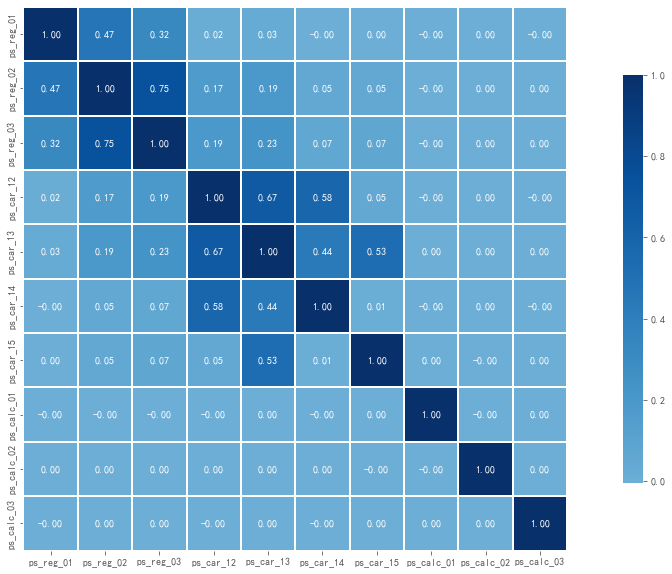

In [ ]:
plt.figure(figsize = [20,10])   # 设置画布大小
sns.heatmap(data = fullset[continuous_cols].corr(), 
            vmax=1,
            center=0,
            square=True,
           annot = True,  # 显示文字
          fmt='.2f',      # 保留两位
           cmap = 'Blues',   # 颜色
           linewidths = .3,  # 分割线宽度
           cbar_kws={"shrink": .75})

![](https://miro.medium.com/max/1225/1*MAr4rWj6zw0Rdo01ecZu1A.png)

> Feature Binning: Conversion of a continuous variable to categorical.
>
>Feature Encoding: Conversion of a categorical variable to numerical features.

## Binning

### Binning Intro

Let's first talk about what binning algorithm is. Literally, it means

“dividing data into different "bins" according to different "rules."

In fact, binning is a type of feature engineering and can be understood as a modeling approach to transform continuous data into discrete data.

-For example: Suppose we have a set of continuous data, such as 25, 14, 68, 43, 63. If the binning logic is defined as 0 for values greater than 50 and 1 for values less than 50, then the final data will become 1, 1, 0, 1, 0. The data is discretized. Of course, there are many ways to perform binning, but the general purpose is to discretize continuous data according to certain rules.

### Unsupervised binning

> Unsupervised binning are of two categories without considering the target class label into account:

（1）Equal frequency binning

This algorithm divides continuous variables into bins with equal width.

From the minimum value to the maximum value, it is evenly divided into $N$ parts. If min and max are the minimum and maximum values, then the length of each interval is $W = (max−min)/N$, and the interval boundary values are min+W, min+2W, ..., min+(N−1)W. Here, only the boundaries are considered, and the number of instances in each bin may be different.

（2）Equal Width Binning

This algorithm divides the data into roughly equal-sized categories. The values of the data are evenly distributed into the formed categories.

The boundary values of the intervals are chosen in such a way that each interval contains approximately the same number of instances. For example, if N=10, each interval should contain roughly 10% of the instances.

$$freq = \frac{N}{n}$$

```diff
@ n = number of categories
@ freq = frequency of a category
@ N = number of values in data
```

### Supervised binning

> The entropy-based binning algorithm categorizes continuous or numerical variables where most values in the bins or categories belong to the same class label. It calculates the entropy of the target class labels and categorizes the splits based on maximum information gain.。

### Benefits of Feature Binning:
 
Its advantages are equivalent to the benefits of data discretization:

1.Adding or removing discrete features is easy, facilitating quick model iteration.

2.Sparse vector dot product operations are fast, and the results are easy to store, making it easy to scale.

3.Discretized features exhibit strong robustness to outliers.

-For example, if a feature represents age (>30 is 1, else 0), without discretization, an outlier like "age 300" could significantly disturb the model.

4.For linear models, expressive power is limited.

-After univariate discretization into N categories, each variable has a separate weight, introducing non-linearity and enhancing model expressiveness.

5.Feature discretization allows for feature cross, transforming M + N variables into M * N variables, further introducing non-linearity and improving expressiveness.

6.The model becomes more stable after feature discretization.

-For instance, if user age is discretized, such as 20-30 as one interval, a user aging by one year won't drastically change their profile. However, samples at the boundaries of intervals might behave oppositely, so choosing interval boundaries is a nuanced task.

7.Feature discretization simplifies the logic of logistic regression models, reducing the risk of overfitting.

8.Missing values can be treated as a separate category in the model.

9.All variables can be transformed to similar scales after discretization.

In [ ]:
import pandas as pd
value_list = [0, 10, 20, 59, 61, 79, 80, 90, 99, 100]

# 等频分箱
value_freq_bins = pd.qcut(value_list, q=5)
# 等距分箱
value_dis_bins = pd.cut(value_list, bins=5)

<div class="alert alert-block alert-success"><b>Step 3</b>: 
    
- Find the unique categories for this categorical
- Find the integer positions, which point to the categories of this
    categorical
    
</div>

In [ ]:
"你的代码"

'你的代码'

<AxesSubplot:ylabel='Count'>

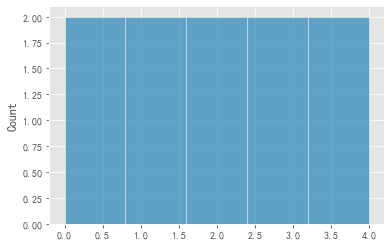

In [ ]:
sns.histplot(value_freq_bins.codes)

<AxesSubplot:ylabel='Count'>

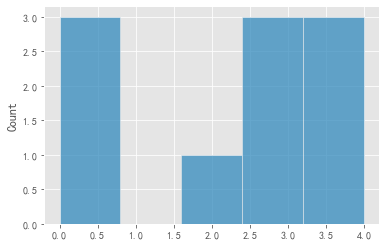

In [ ]:
sns.histplot(value_dis_bins.codes)

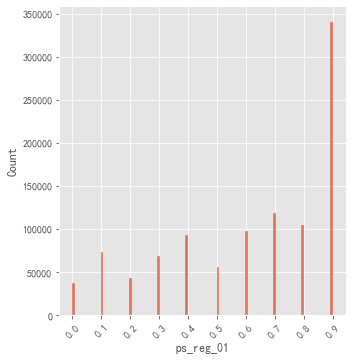

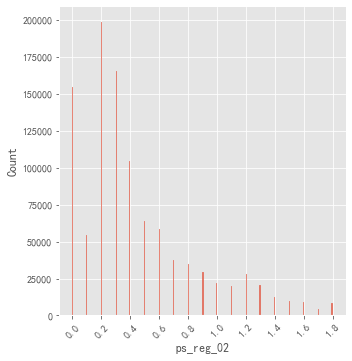

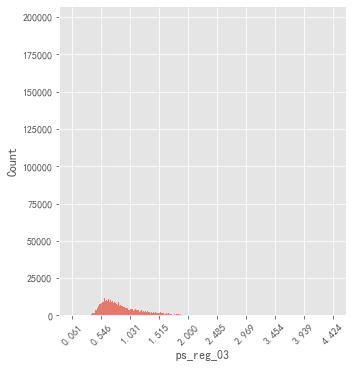

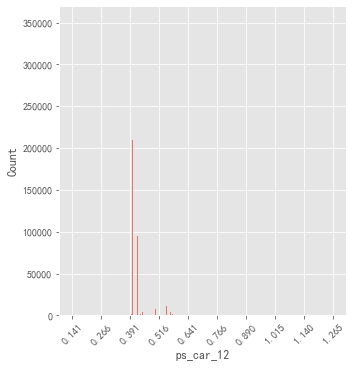

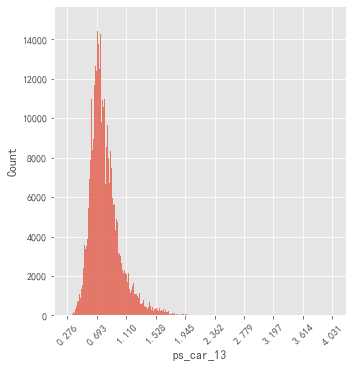

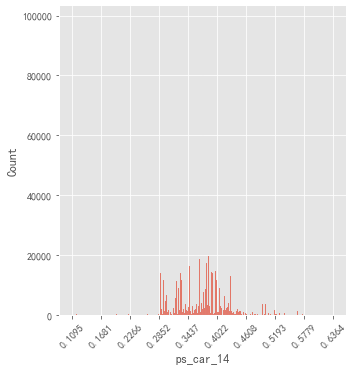

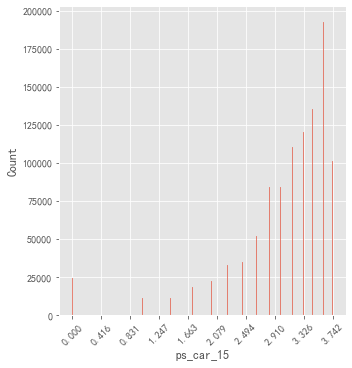

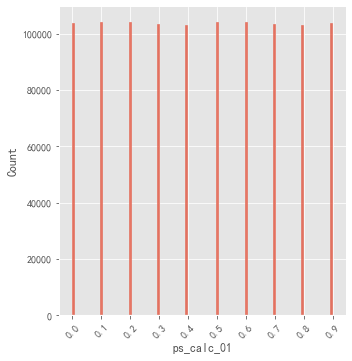

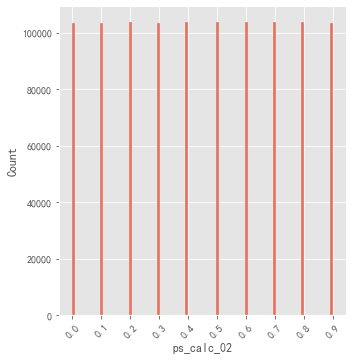

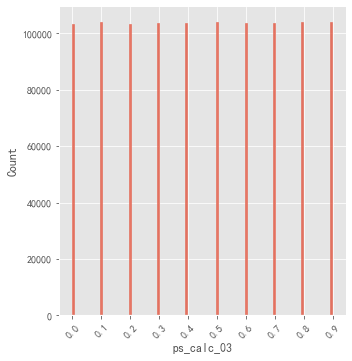

In [ ]:
for col in continuous_cols:
    sns.displot(fullset[col])
    plt.xticks(ticks = np.linspace(start = fullset[col].min(),
                                  stop = fullset[col].max(),
                                  num = 10),rotation = 45)

<div class="alert alert-block alert-success"><b>Step 4</b>: 
    
1. WOE的意义
2. 如何计算WOE
3. WOE编码的意义
    
</div>

In [ ]:
def woe_iv_encoding(data, feat, target, max_intervals, verbose = False):
    
    feat_bins = pd.qcut(x = data[feat], q = max_intervals, duplicates='drop')
    gi = pd.crosstab(feat_bins,data[target])
    gb = pd.Series(data=data[target]).value_counts()

    bad = gi[1]/gi[0]
    good = gb[1]/gb[0]

    # 计算woe
    woe = np.log(bad) - np.log(good)

    # 计算iv
    iv = (bad-good)*woe

    # 计算整个特征的iv
    f_iv = iv.sum()  # 5.2958917587905745
    if verbose == True:
        print(f"根据当前的间隔数{max_intervals}，特征{feat}所计算的总information value为：{f_iv}")
        print('='*80)

    # 进行映射操作
    dic = iv.to_dict()

    iv_bins = feat_bins.map(dic)  # 连续型变量离散化

    return iv_bins.astype('float64')

![](https://miro.medium.com/max/1156/1*5S_5aAHWe0_knDGZUK3W8w.png)

In [ ]:
for col in continuous_cols:
    fullset[f"{col}_woe"] = woe_iv_encoding(data = fullset, feat = col, target = 'target', max_intervals = 20)
    #sns.displot(fullset_copy[f"{col}_woe"])

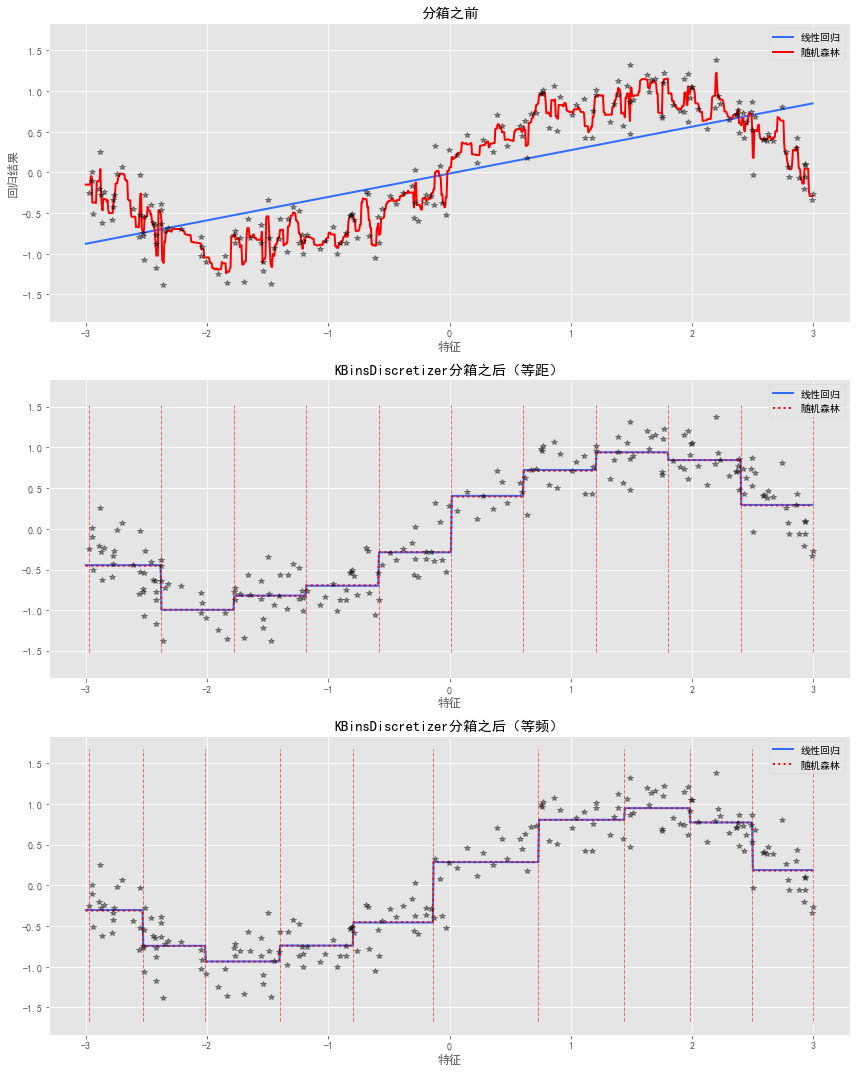

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor

# construct the dataset
rnd = np.random.RandomState(2022)
X = rnd.uniform(-3, 3, size=200)
y = np.sin(X) + rnd.normal(size=len(X)) / 4
X = X.reshape(-1, 1)

# transform the dataset with KBinsDiscretizer
enc1 = KBinsDiscretizer(n_bins=10, encode="onehot", strategy = 'uniform')
enc2 = KBinsDiscretizer(n_bins=10, encode="onehot", strategy = 'quantile')
X_binned_unif = enc1.fit_transform(X)
X_binned_quan = enc2.fit_transform(X)

# predict with original dataset
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1,nrows = 3, sharey=True, figsize=(12,5*3))
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)
reg = LinearRegression().fit(X, y)


ax1.plot(line, reg.predict(line), linewidth=2, color="#306dff", label="线性回归")
reg = RandomForestRegressor(random_state=0).fit(X, y)
ax1.plot(line, reg.predict(line), linewidth=2, color="red", label="随机森林")
ax1.plot(X[:, 0], y, "*", c="k",alpha = .4)
ax1.legend(loc="best")
ax1.set_ylabel("回归结果")
ax1.set_xlabel("特征")
ax1.set_title("分箱之前")

# predict with transformed dataset
line_binned_unif = enc1.transform(line)
reg = LinearRegression().fit(X_binned_unif, y)
ax2.plot(
    line,
    reg.predict(line_binned_unif),
    linewidth=2,
    color="#306dff",
    linestyle="-",
    label="线性回归",
)

reg = RandomForestRegressor(random_state=0).fit(X_binned_unif, y)
ax2.plot(
    line,
    reg.predict(line_binned_unif),
    linewidth=2,
    color="red",
    linestyle=":",
    label="随机森林",
)
ax2.plot(X[:, 0], y, "*", c="k", alpha = .4)
ax2.vlines(enc1.bin_edges_[0], *plt.gca().get_ylim(), linewidth=1,alpha= .6, color = '#fc1b1b',linestyles = '--')
ax2.legend(loc="best")
ax2.set_xlabel("特征")
ax2.set_title("KBinsDiscretizer分箱之后（等距）")

# predict with transformed dataset
line_binned_quan = enc2.transform(line)
reg = LinearRegression().fit(X_binned_quan, y)
ax3.plot(
    line,
    reg.predict(line_binned_quan),
    linewidth=2,
    color="#306dff",
    linestyle="-",
    label="线性回归",
)

reg = RandomForestRegressor(random_state=0).fit(X_binned_quan, y)
ax3.plot(
    line,
    reg.predict(line_binned_quan),
    linewidth=2,
    color="red",
    linestyle=":",
    label="随机森林",
)
ax3.plot(X[:, 0], y, "*", c="k", alpha = .4)
ax3.vlines(enc2.bin_edges_[0], *plt.gca().get_ylim(), linewidth=1, alpha= .6, color = '#fc1b1b',linestyles = '--')
ax3.legend(loc="best")
ax3.set_xlabel("特征")
ax3.set_title("KBinsDiscretizer分箱之后（等频）")

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success"><b>Step 5</b>: 
    
- 根据上图，完善代码！
- 请叙述 pd.qcut 和 pd.cut 的区别，我们在变量离散化时用哪个更好？
- pd.qcut 和 pd.cut 和 KBinsDiscretizer 的区别？
- 根据这个例子你有什么启发？（开放）
    
</div>

## feature scaling 


### Standardization

![](https://miro.medium.com/max/1400/1*UPLv3kNw9JTtNabr70dQDQ.png)

feature scaling 的一种！

> Standardization is the process of developing, promoting and possibly mandating standards-based and compatible technologies and processes within a given industry.

sklearn实现：https://scikit-learn.org/stable/modules/preprocessing.html

Therefore, all our features will now have zero mean and unit variance. This means that we can now compare the variances between features.

In other words, for each sample in the dataset, we subtract the mean $\mu$ and divide by the standard deviation $\sigma$. 

$$\frac{x-\mu}{\sigma}$$

By removing the mean from each sample, we effectively shift the samples toward a mean of 0 (after all, we have removed it from all samples). Additionally, by dividing by the standard deviation, we obtain a dataset where the values describe how many standard deviations they deviate from the mean.

```python
import numpy as np
dataset = np.array([1.0, 2.0, 3.0, 3.0, 3.0, 2.0, 1.0])
standardized_dataset = (dataset - np.average(dataset)) / (np.std(dataset))
print(standardized_dataset)
```

优点：
1. z-score计算简单
2. 不受数据量级影响

缺点：

1. 总体均值和方差很难估算
2. 需要数据呈正态分布
3. 去除数据实际意义，需要`inverse_transform`

---

### Normalization

![](https://miro.medium.com/max/1225/1*GkLMjpUYVYWQdy69psVbEw.png)

feature scaling 的一种！


sklearn实现：https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html


```python
import numpy as np
dataset = np.array([1.0, 12.4, 3.9, 10.4])
normalized_dataset = (dataset - np.min(dataset)) / (np.max(dataset) - np.min(dataset))
print(normalized_dataset)
```

Advantages:

-Simple calculation of z-score.
-ot influenced by data scale.

Disadvantages:

-Difficult to estimate population mean and variance accurately.
-Assumes that the data follows a normal distribution.
-Removing the data's actual meaning; inverse_transform is needed to interpret the results.

### Normalization vs. Standardization

（1）标准化与归一化的异同

(1) Similarities:

-Both can eliminate errors caused by different units of measurement.
-Both are linear transformations.
-Both involve compressing and then shifting the vector X in proportion.
-Both require inverse_transform.

(2) Differences:

**Purpose:**

-Normalization is to compress the range of values to [0,1].
-Standardization is to adjust the overall distribution of features.

**Assumptions:**

-Normalization has no assumptions.
-Standardization assumes the data follows a normal distribution.

**Calculation Logic:**

-Normalization is related to the minimum and maximum values.
-Standardization is related to the mean and standard deviation.

**Output Range:**

-Normalization outputs values in the [0,1] range.
-Standardization has no restrictions.

(3) When to Use Normalization vs. Standardization:

-Use normalization if there are specific requirements for the output range.
-Use normalization if the data is relatively stable with no extreme maximum and minimum values.
-Use standardization if the data contains outliers and significant noise.

(4) Applications of Normalization and Standardization:

-Standardization (Z-score standardization) performs better in classification, clustering algorithms (e.g., SVM, KNN), or when using PCA for dimensionality reduction.
-For non-distance-based methods, or when data does not adhere to normal distribution, other normalization methods can be used.
-Tree-based methods, like random forests, bagging, and boosting, do not require feature normalization.

**In general, it is recommended to prioritize standardization. Explore other methods, such as normalization or more complex techniques, when there are specific requirements for the output. Many methods can adjust the output range to [0,1], but for more effective transformations based on distribution assumptions, consider using corresponding probability density functions.**

**In addition to the methods mentioned, there are also less commonly used techniques like RobustScaler, PowerTransformer, QuantileTransformer, and others.**

参考：https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

### Statistical Transformation

Purposes:

1.Stabilize variance
2.Always keep the distribution close to a normal distribution
3.Make data independent of the distribution's mean
4.Suitable for skewed distributions

![](https://www.researchgate.net/profile/Matthieu-Komorowski-2/publication/308007227/figure/fig20/AS:668378712772624@1536365311541/Example-of-the-effect-of-a-log-transformation-on-the-distribution-of-the-dataset.png)

其他：
1. Square Root Transformation
2. Cube Root Transformation
3. Box-Cox：https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html


> By performing these transformations, the dataset typically becomes more normally distributed.


## Enhancement

关于特征增强，可以考虑两个方向：

（1）增加有用的特征：

- 通过业务常识去造特征
> 比如时间特征展开拆解，想办法拓宽特征池
- 特征交互
> 交互组合产生新的特征

（2）去掉有害的特征，即特征降维

- 从原始特征集中去掉部分特征，这部分技术通常称为特征选择；
- 将原始特征集映射为一个新的低维特征集，从而过滤掉高维空间中的噪声，这部分技术可以称为特征变换

### 特征交互

鉴于变量之间的较强相关性，我不能把他们都带入模型中，因为相关特征不能提升模型表现，对于：

1. 线性模型

会出现多重共线性的问题，从而导致解析解的波动较大，方差较大，不稳定。

2. 树形模型

树形模型基于各特征的信息增益对其分割，适合处理不同特征之间的交互性，但是高相关性会掩盖其中的【交互性】。

- Feature correlation

特征的相关性是说，不考虑target，两个特征之间是互相依赖的，或者说，如果我增大特征A的值，特征B的值也会发生线性的变化（变大或者变小）。

- Feature Interaction

特征交互性是说，现在有两个不相关的特征，比如：房子大小（特征A）和房子的位置（特征B），他们并不相关，我们的target是房价（要去预测的），那么这俩特征交互起来，或者说以某种方式合并起来，是不是会有`1+1>2`的效果，比如基本的【加减乘除】的组合。

所以总结起来：

![1XhJa.png](https://i.imgtg.com/2022/06/15/1XhJa.png)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

interactions = pd.DataFrame(data=poly.fit_transform(fullset[continuous_cols]), 
                            columns=poly.get_feature_names_out(continuous_cols))


interactions.drop(continuous_cols, axis=1, inplace=True)  # Remove the original columns
# Concat the interaction variables to the train data
print('特征交互前，训练集有 {}个变量 '.format(fullset.shape[1]))
fullset = pd.concat([fullset, interactions], axis=1)
print('特征交互后，训练集有 {}个变量'.format(fullset.shape[1]))

特征交互前，训练集有 67个变量 
特征交互后，训练集有 112个变量


<div class="alert alert-block alert-success"><b>Step 6</b>: 
    
- 简述【特征交互】的意义和原理
- 请叙述 PolynomialFeatures 的 degree、interaction_only、include_bias的含义
    
</div>

### PCA

参考：

- sklearn实现：https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- 通俗理解pca：https://blog.csdn.net/HLBoy_happy/article/details/77146012
- pca原理总结：https://www.cnblogs.com/pinard/p/6239403.html


PCA执行中...
Total Explained variance: 0.9948


Text(0, 0.5, '第二主成分解释 2.5 % 方差')

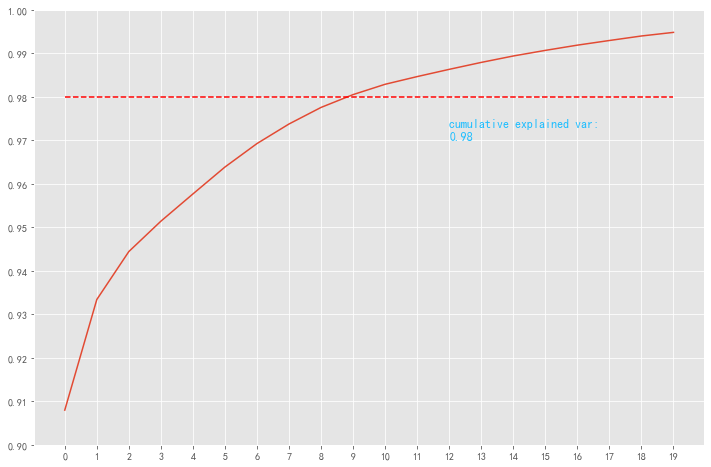

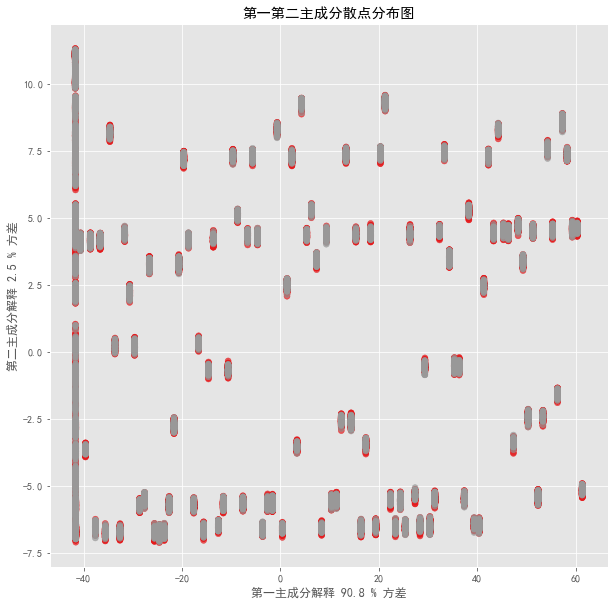

In [ ]:
from sklearn.decomposition import PCA

X = train.drop(['id', 'target'], axis=1)
y = train.target

n_comp = 20
print('\nPCA执行中...')
pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
X_pca = pca.fit_transform(X)
print('Total Explained variance: %.4f' % pca.explained_variance_ratio_.sum())


plt.figure(figsize = [12,8])

pd.Series(pca.explained_variance_ratio_).cumsum().plot()

plt.plot(range(n_comp),[0.98]*20, 'r--')
plt.xticks(ticks = range(n_comp))
plt.yticks(ticks = np.linspace(0.9,1,11))
plt.text(12,0.97,'cumulative explained var: \n0.98',fontsize = 12, color = '#20beff')

plt.figure(figsize=(10,10))
plt.scatter(X_pca[:,0],X_pca[:,1],c=y,cmap='Set1',alpha = .7)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title(
        "第一第二主成分散点分布图")
plt.xlabel("第一主成分解释 %.1f %% 方差" % (
        pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("第二主成分解释 %.1f %% 方差" % (
        pca.explained_variance_ratio_[1] * 100.0))

<div class="alert alert-block alert-success"><b>Step 6</b>: 
    
- 对上面代码每一行进行comment
</div>

### GBDT+LR


本质上GBDT+LR是一种具有stacking思想的二分类器模型，所以可以用来解决二分类问题。

论文：https://www.semanticscholar.org/paper/Practical-Lessons-from-Predicting-Clicks-on-Ads-at-He-Pan/daf9ed5dc6c6bad5367d7fd8561527da30e9b8dd?p2df

![](https://d3i71xaburhd42.cloudfront.net/daf9ed5dc6c6bad5367d7fd8561527da30e9b8dd/2-Figure1-1.png)

- 应用：CTR点击率预估（预测当给用户推送的广告会不会被用户点击）。
- 场景：训练样本量级大（PB级别）
- 优势：
    - LR线性模型，速度快但是学习能力有限，没有特征组合、筛选的能力
    - GBDT树形模型，可挖掘有区分度的特征，减少特征工程人力成本

参考资料：
1. https://blog.csdn.net/shine19930820/article/details/71713680
2. https://www.zhihu.com/question/35821566
3. https://www.cnblogs.com/pinard/tag/%E7%89%B9%E5%BE%81%E5%B7%A5%E7%A8%8B/
4. https://github.com/neal668/LightGBM-GBDT-LR/blob/master/GBFT%2BLR_simple.py

<div class="alert alert-block alert-success"><b>Step 7</b>: 
    
    
   - GBDT+LR的优势有哪些？解决什么问题？
</div>

其实gbdt+lr类似于做了一个stacking。

gbdt+lr模型中，把gbdt的叶子节点作为lr的输入，而gbdt的叶子节点相当于它的输出y，用这个y作为lr的x，和stacking是类似的。

但是这里和一般的stacking有些差别，stacking的话是多个模型的y作为stacking模型的输入，训练出这个stacking模型，然后stacking模型的输出作为最终结果。而gbdt+lr是每个叶子节点作为这个y。

另外gbdt的每棵树其实是拟合上一颗树的残差上求得的局部最优解，把所有局部最优解的输出通过lr训练得到一个全局最优解

所以这是gbdt+lr比单用gbdt强的地方！

那么对于lr呢？


- lr简单，能够处理超高纬度稀疏问题（sparse）。但是lr特征组合能力差（需要很强的特征工程！）。gbdt+lr相当于对原始特征通过gbdt进行了特征组合
- gbdt对**连续特征**划分能力强，可以帮助lr处理连续特征，避免了人工对连续特征分箱操作（也就是连续变量离散化，分箱）

## Selection

### 基于统计指标

In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=.01)
selector.fit(fullset.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = fullset.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))

19 variables have too low variance.


### 基于模型指标

In [ ]:
from xgboost import XGBClassifier
from xgboost import plot_importance

plt.figure(figsize = [100,20])

X = fullset.loc[train.index].drop(['id', 'target'], axis=1)
y = fullset.loc[train.index].target

model = XGBClassifier()

model.fit(X, y)
# plot feature importance

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<Figure size 7200x1440 with 0 Axes>

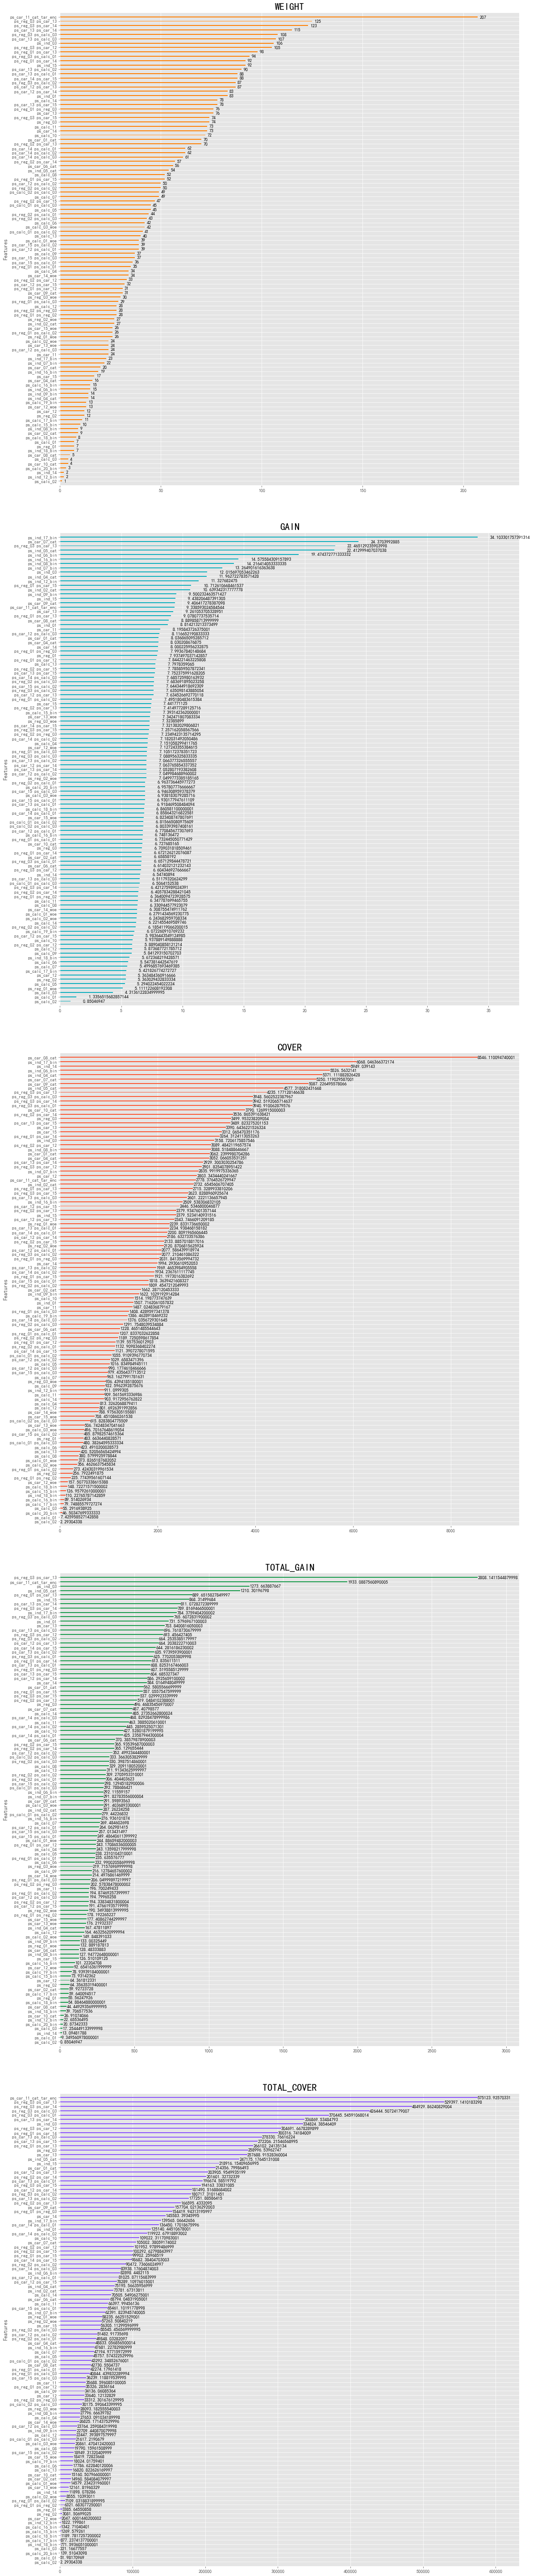

In [ ]:
# define subplot grid
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15, 80))
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
# loop through tickers and axes
colors = ['#ff7f01','#08aebd','#fc5531','#139948','#8950fe']
for ty, ax, color in zip(types, axs.ravel(), colors):
    # filter df for ticker and plot on specified axes
    plot_importance(ax = ax, booster = model,importance_type=ty, color = color)

    # chart formatting
    ax.set_title(ty.upper(),fontsize = 22)
    ax.set_xlabel("")

plt.show()

<div class="alert alert-block alert-success"><b>Step 8</b>: 
    
    
   - 'weight', 'gain', 'cover' 这三种衡量特征重要度的strategy区别是什么？
</div>

看这儿！https://www.jianshu.com/p/2920c97e9e16

In [ ]:
# 特征工程的strategy作为key，对应的变量名组成的list作为value
from sklearn.feature_selection import SelectFromModel
feat_dict = {}
for thres in ['median','mean','1.25*mean']:
    model_select = SelectFromModel(model, threshold=thres, prefit=True)
    print(f'筛选前总计：{X.shape[1]}个特征')
    n_features = model_select.transform(X.values).shape[1]
    print(f'筛选后总计： {n_features}个特征【{thres}】')
    print('#'*60)
    selected_vars = list(X.columns[model_select.get_support()])
    feat_dict[thres] = selected_vars

筛选前总计：110个特征
筛选后总计： 55个特征【median】
############################################################
筛选前总计：110个特征
筛选后总计： 28个特征【mean】
############################################################
筛选前总计：110个特征
筛选后总计： 13个特征【1.25*mean】
############################################################


In [ ]:
for ty in types:
    feat_dict[ty] = list(model.get_booster().get_score(importance_type=ty).keys())

In [ ]:
final_train = fullset.loc[train.index][feat_dict['mean']+['target']]
final_test = fullset.loc[test.index][feat_dict['mean']]

In [ ]:
final_train.to_csv("final_train.csv")
final_test.to_csv("final_test.csv")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=185fc705-b61f-4bb6-be30-c3c88dd0b19b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>